# Imports and data read in 

In [1]:
from pat_tools import feat_and_lab, decision_tree, random_forest, plot_conmat, make_conmat, independence_test, impute_features
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# Extract features and labels
features, labels = feat_and_lab("Data.csv")

label = 'has_dep_diag'

# Analysis

## Independence tests

In [3]:
# Check which features pass the chi-squared test
dependence_dict = independence_test(features, labels, label)

In [4]:
# Drop independent features
for feature, dependence in dependence_dict.items():
    if not dependence:
        features.drop(feature, axis=1, inplace=True)

## Decision tree

In [3]:
imped_features = impute_features(features)

# Decision tree
dt_test, dt_pred, tree = decision_tree(imped_features, labels, chosen_label=label)
dt_conmat = make_conmat(dt_pred, dt_test)

# Random forest
rf_test, rf_pred = random_forest(imped_features, labels, chosen_label=label)
rf_conmat = make_conmat(rf_pred, rf_test)

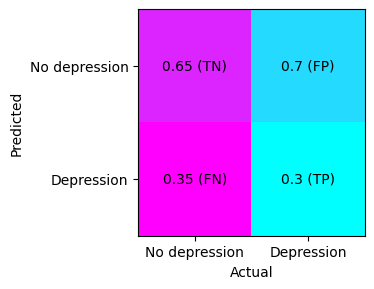

In [4]:
# Show dt confusion matrix
plot_conmat(dt_conmat)

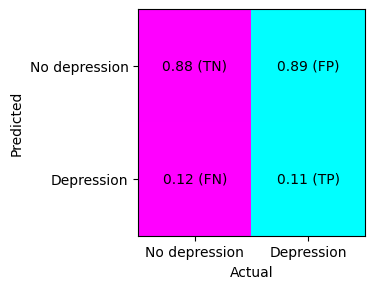

In [5]:
# Show rf confusion matrix
plot_conmat(rf_conmat)

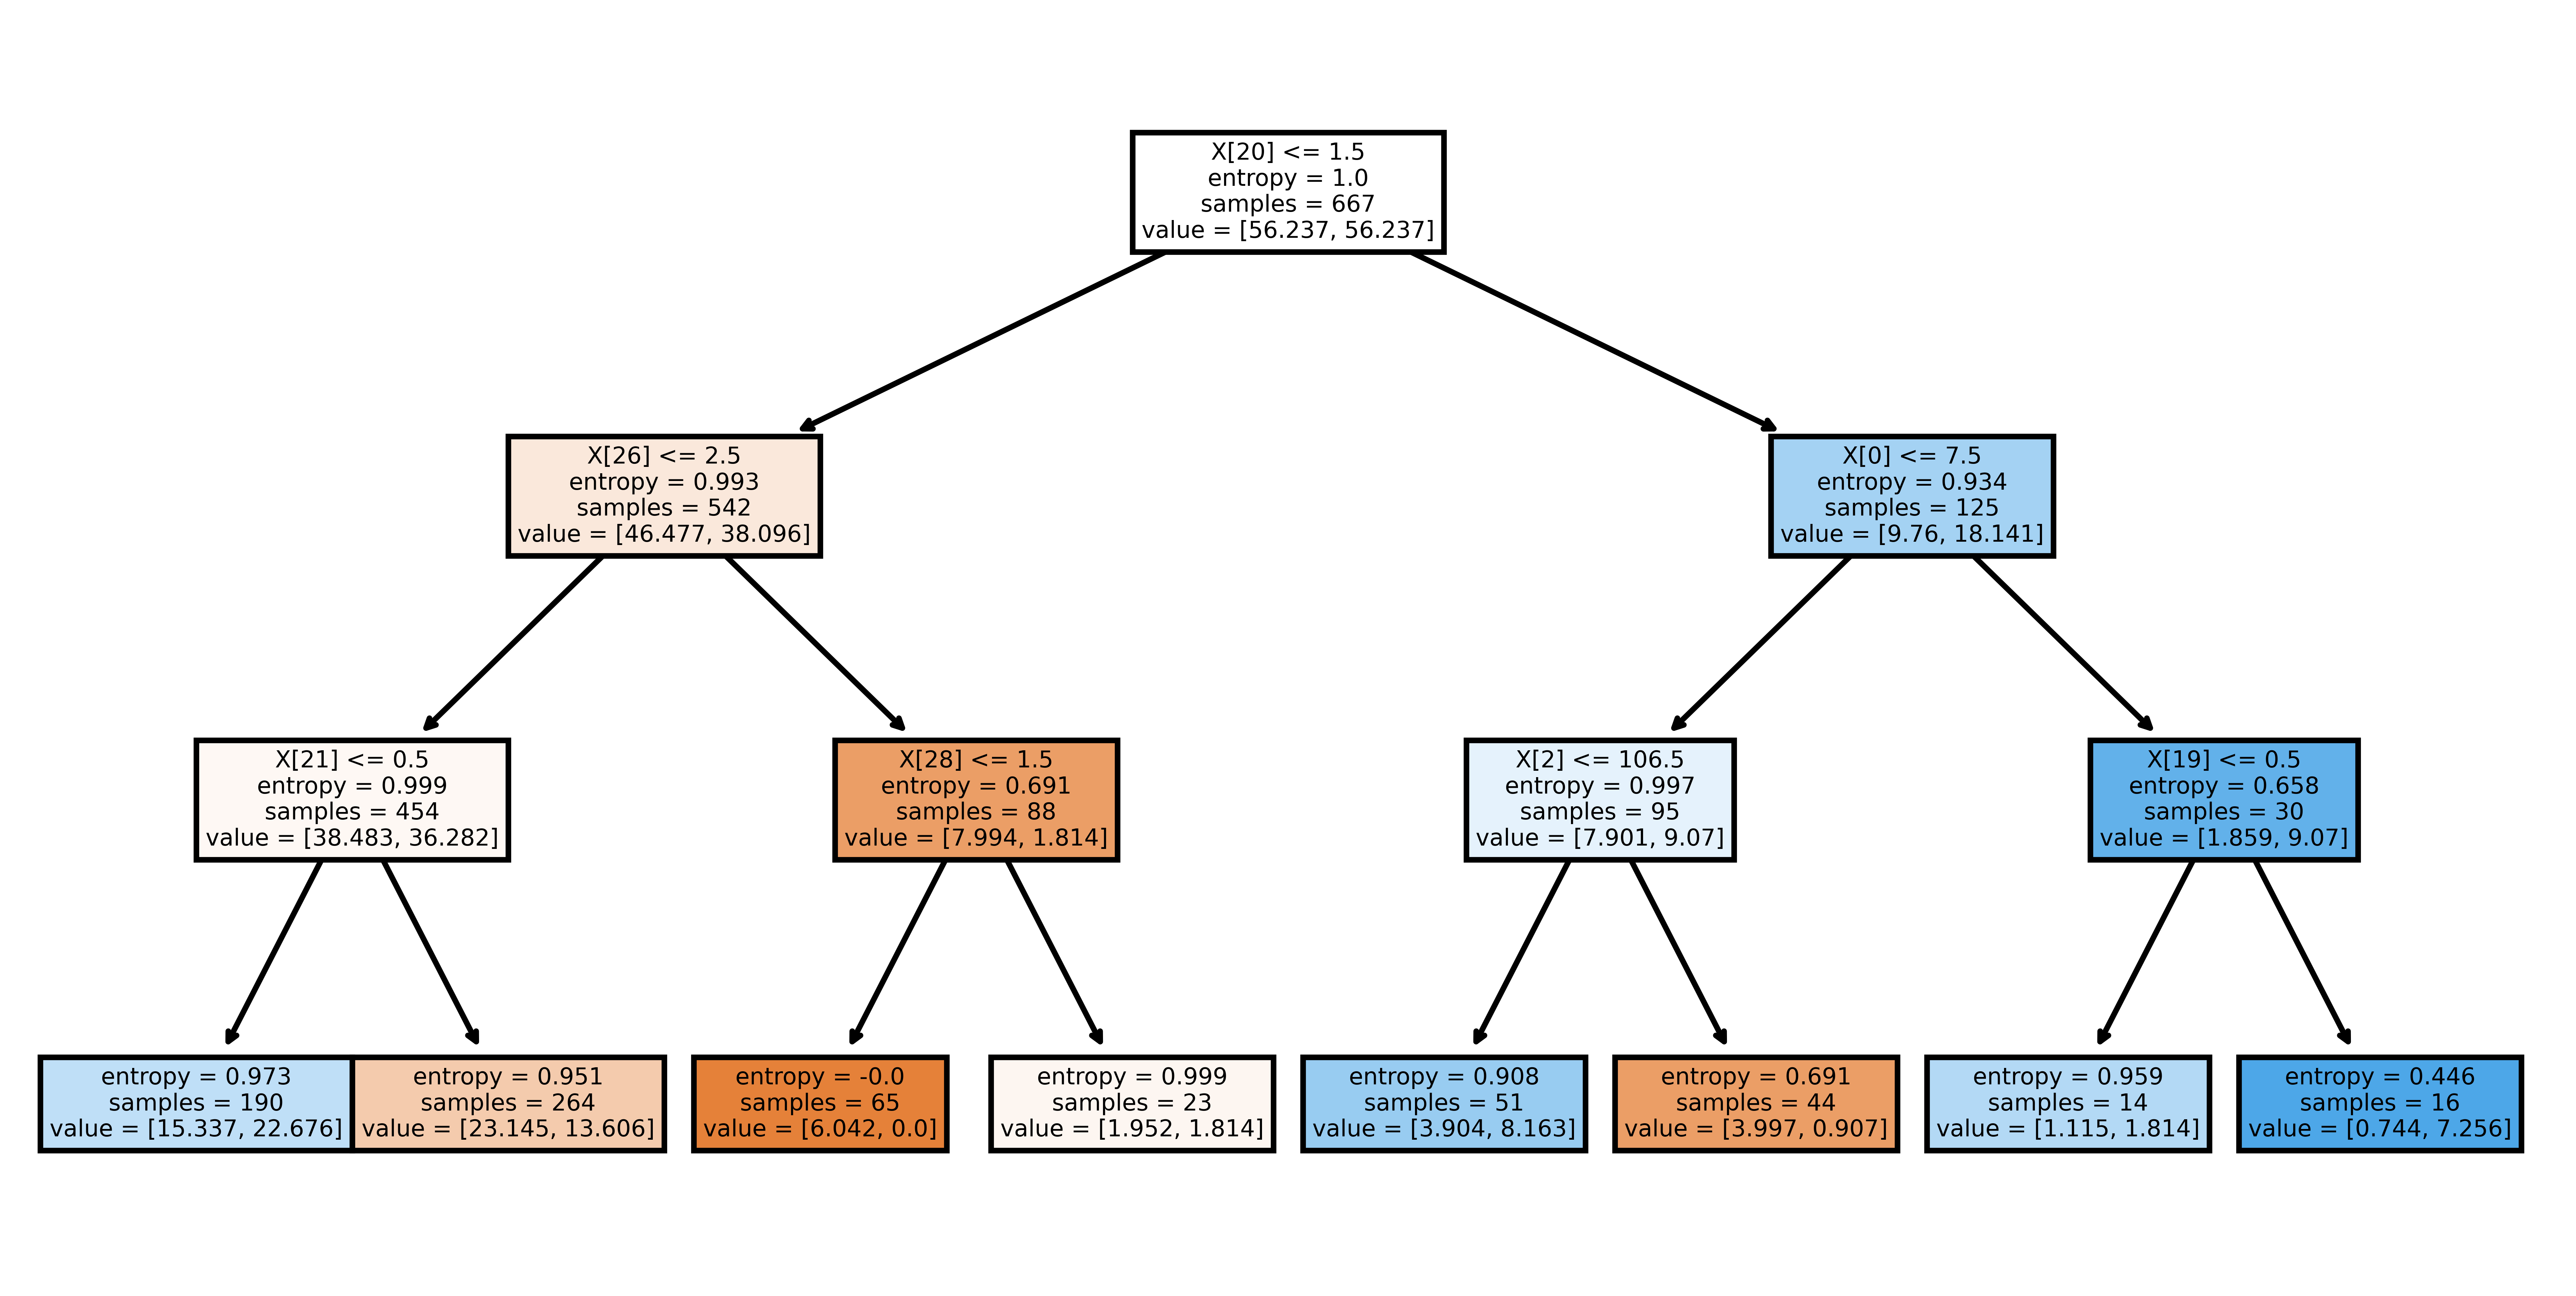

In [5]:
fig, ax = plt.subplots(figsize=(8,4), dpi=1200)

plot_tree(tree, ax=ax, filled=True)
plt.show()